In [62]:
import numpy as np
import mnist_reader
import keras
import itertools
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation, BatchNormalization
from keras.utils.generic_utils import get_custom_objects
from keras.models import Sequential
from keras import regularizers
from keras import backend as K
import tensorflow as tf 
from sklearn import manifold
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score,f1_score
from scipy.stats import mode
import matplotlib.pyplot as plt
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
def swish(x):
    return (K.sigmoid(x) * x)
get_custom_objects().update({'swish': swish})

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15112674383378801272
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11323890074
locality {
  bus_id: 1
}
incarnation: 15214618671506418297
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:04:00.0, compute capability: 3.5"
]


In [63]:
batch_size = 32
num_classes = 10
epochs = 10

In [64]:
X_train,y_train=mnist_reader.load_mnist('../data/Fashion-MNIST/', kind='train')
y_train = keras.utils.to_categorical(y_train, num_classes)
X_train=X_train.reshape([-1,28,28,1])
X_train=X_train/255
X_train.shape

(60000, 28, 28, 1)

In [90]:
folder='../data/CIFAR-10/'
for i in range(1,6):
    fname='data_batch_'+str(i)
    batch=unpickle(folder+fname)
    tmp_images=batch[b'data'].reshape([-1, 3, 32, 32])
    if i==1 :
        X_train=tmp_images.transpose([0, 2, 3, 1])
        y_train=np.array(batch[b'labels'])
    else:
        X_train=np.vstack((X_train,tmp_images.transpose([0, 2, 3, 1])))
        y_train=np.append(y_train,np.array(batch[b'labels']))
y_train = keras.utils.to_categorical(y_train, num_classes)
X_train = X_train/128
X_train.shape

(50000, 32, 32, 3)

In [40]:
folder='../data/CIFAR-10/'
n_classes=10
fname='test_batch'
test=unpickle(folder+fname)
tmp_images=test[b'data'].reshape([-1, 3, 32, 32])
x_test=tmp_images.transpose([0, 2, 3, 1])
y_test=np.array(test[b'labels'])
y_test=keras.utils.to_categorical(y_test, n_classes)
x_test=x_test/255

In [ ]:
def keras_nn(input_shape):
    net=Sequential()
    net.add(Flatten())
    net.add(Dense(512, activation='relu', input_shape=(input_shape,)))
    net.add(Dropout(0.2))
    net.add(Dense(512, activation='relu'))
    net.add(Dropout(0.2))
    net.add(Dense(num_classes, activation=tf.nn.softmax))
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
    net.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    return net

In [94]:
def keras_cnn(input_shape,n_fil,act,init='lecun_normal'):
    net=Sequential()
    net.add(Conv2D(n_fil[0], (4, 4), padding='same',input_shape=input_shape,kernel_initializer=init))
    net.add(BatchNormalization())
    #net.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    for i in range(len(n_fil)):
        if(i == len(n_fil)-1):
            net.add(Dropout(0.25))
            net.add(Flatten())
            net.add(Dense(400,activation='elu',kernel_initializer=init))
            net.add(Dropout(0.5))
            net.add(Dense(128,activation='tanh',kernel_initializer=init))
            net.add(Dropout(0.5))
            #net.add(Dense(10,activation=tf.nn.softmax,kernel_initializer=init))
            net.add(Dense(10,activation='softmax',kernel_initializer=init))
        else:
            net.add(Conv2D(n_fil[i+1],(3,3), padding='same',activation=act,kernel_initializer=init))
            net.add(BatchNormalization())
            if(i % 1 == 0):
                net.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    
    #opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
    opt = keras.optimizers.Adadelta()
    #opt = keras.optimizers.Adam()
    net.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=opt,
                  metrics=['accuracy'])
    return net

In [95]:
conv=keras_cnn(X_train.shape[1:],[8,32,32],'relu')
conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 32, 32, 8)         392       
_________________________________________________________________
batch_normalization_29 (Batc (None, 32, 32, 8)         32        
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 32)        2336      
_________________________________________________________________
batch_normalization_30 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
batch_normalization_31 (Batc (None, 16, 16, 32)        128       
__________

In [7]:
max_train=40000  
X_test=X_train[max_train:]
y_test=y_train[max_train:]
net=keras_nn(32*32*3)
net.fit(X_train[:max_train], y_train[:max_train], batch_size=64,epochs=20,shuffle=True,validation_data=(X_test,y_test))

NameError: name 'keras_nn' is not defined

In [96]:
max_train=-1
#X_test=X_train[max_train:]
#y_test=y_train[max_train:]
conv.fit(X_train[:max_train], y_train[:max_train], batch_size=64,epochs=30,shuffle=True,validation_data=(X_test,y_test))

Train on 49999 samples, validate on 25000 samples
Epoch 1/30
49999/49999 [==============================] - 40s 803us/step - loss: 1.5229 - acc: 0.4569 - val_loss: 1.2333 - val_acc: 0.5665
Epoch 2/30
49999/49999 [==============================] - 38s 752us/step - loss: 1.1224 - acc: 0.6087 - val_loss: 1.1125 - val_acc: 0.6127
Epoch 3/30
49999/49999 [==============================] - 39s 785us/step - loss: 0.9802 - acc: 0.6630 - val_loss: 0.8244 - val_acc: 0.7164
Epoch 4/30
49999/49999 [==============================] - 39s 779us/step - loss: 0.9064 - acc: 0.6922 - val_loss: 1.1916 - val_acc: 0.6044
Epoch 5/30
49999/49999 [==============================] - 38s 762us/step - loss: 0.8493 - acc: 0.7132 - val_loss: 1.0317 - val_acc: 0.6635
Epoch 6/30
49999/49999 [==============================] - 43s 865us/step - loss: 0.7979 - acc: 0.7313 - val_loss: 0.6893 - val_acc: 0.7659
Epoch 7/30
49999/49999 [==============================] - 41s 811us/step - loss: 0.7612 - acc: 0.7434 - val_loss: 0.

In [87]:
y_pred=np.argmax(conv.predict(X_test),axis=1)
Y_test=np.argmax(y_test,axis=1)
acc=accuracy_score(Y_test[-10000:],y_pred[-10000:])
f1_mic=f1_score(Y_test[-10000:],y_pred[-10000:],average='micro')
f1_mac=f1_score(Y_test[-10000:],y_pred[-10000:],average='macro')
print("Test Accuracy ::",acc)
print("Test Macro F1-score ::",f1_mac)

Test Accuracy :: 0.7221
Test Macro F1-score :: 0.7212128652135202


In [73]:
X_test.shape

(30000, 28, 28, 1)

In [85]:
get_embed = K.function([conv.layers[0].input], [conv.layers[-2].output])
embed=get_embed([X_test[-10000:]])[0]
cluster=KMeans(n_clusters=num_classes).fit(embed)
embed.shape

(10000, 32)

In [31]:
tsne=manifold.TSNE(n_components=2)
X_embed=tsne.fit_transform(embed[-1000:])
y_labels=np.argmax(y_test[-1000:],axis=1)

In [86]:
y_labels=np.argmax(y_test[-10000:],axis=1)
pred=cluster.labels_[-10000:]
labels=np.zeros_like(pred)
for i in range(10):
    mask=(pred==i)
    labels[mask]=mode(y_labels[mask])[0]
accuracy_score(y_labels,labels),f1_score(y_labels,labels,average='macro')

(0.7226, 0.7222819608337824)

In [ ]:
np.argmax(conv.predict(X_test[-100:]),axis=1), y_test[-100:]

<function matplotlib.pyplot.show(*args, **kw)>

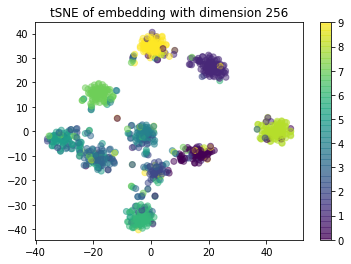

In [33]:
plt.scatter(X_embed[:,0],X_embed[:,1],c=y_labels.astype(int),alpha=0.5)
plt.colorbar()
plt.title('tSNE of embedding with dimension 256')
plt.savefig('tsne_cifar.png',dpi=300)
plt.show

In [ ]:
plt.scatter(X_embed[:,0],X_embed[:,1],c=labels,alpha=0.5)
plt.colorbar()
plt.title('tSNE of embedding colored by k-means cluster')
plt.savefig('cluster_fashion.png',dpi=300)
plt.show

In [ ]:
def keras_cnn(input_shape,n_fil,act):
    net=Sequential()
    net.add(Conv2D(n_fil[0], (3, 3), padding='same',input_shape=input_shape))
    for i in range(len(n_fil)):
        if(i == len(n_fil)-1):
            net.add(Dropout(0.25))
            net.add(Flatten())
            net.add(Dense(512,activation='relu'))
            net.add(Dropout(0.5))
            net.add(Dense(10,activation=tf.nn.softmax))
        else:
            net.add(Conv2D(n_fil[i+1],(3,3), padding='same',activation=act))
            if(i % 2 == 0):
                net.add(MaxPooling2D(pool_size=(2, 2)))
    
    #opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
    opt = keras.optimizers.Adadelta()
    #opt = keras.optimizers.Adam()
    # Train the model using RMSprop
    net.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=opt,
                  metrics=['accuracy'])
    return net

In [98]:
from keras.models import load_model
conv.save('model_CIFAR-10.h5')

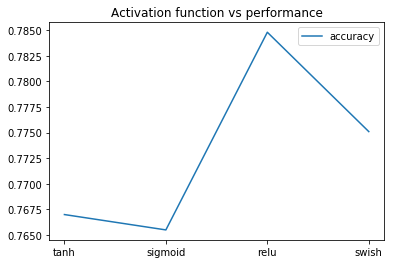

In [59]:
accu=[0.767,0.7655,0.7848,0.7751]
#f1_score=[0.7748,0.8029,0.7953,0.8088]
n_layers=['tanh','sigmoid','relu','swish']
#n_layers=[8,16,32,64]
plt.plot(n_layers,accu,label="accuracy")
#plt.plot(n_hid,f1micro,label="f1_micro")
#plt.plot(n_layers,f1_score,label="f1_score")
#ax=plt.subplot(313)
plt.legend()
plt.title('Activation function vs performance')
plt.savefig('part_2_task_3.png',dpi=300)
plt.show()